# Binary Human-Written vs Machine-Generated Text Classification

### Imports

In [73]:
# Run this cell to install the required packages

#TODO: add all packages that need to be installed in colab
# !pip install ipywidgets   #TODO: test if ipywidgets works also in colab or if must use @param etc.

In [74]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from ipywidgets import interact

## Data Loading

In [75]:
# train_data = []
# with open('./data/subtaskA_train_monolingual.jsonl') as f:
#     for line in f:
#         train_data.append(json.loads(line))
    
# test_data = []
# with open('./data/subtaskA_dev_monolingual.jsonl') as f:
#     for line in f:
#         test_data.append(json.loads(line))
# TODO: remove

In [76]:
train_df = pd.read_json(path_or_buf='./data/subtaskA_train_monolingual.jsonl', lines=True)
train_df.set_index('id',inplace=True)

test_df = pd.read_json(path_or_buf='./data/subtaskA_dev_monolingual.jsonl', lines=True)
test_df.set_index('id',inplace=True)

In [77]:
train_df.head()

,text,label,model,source
id,,,,
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow


In [78]:
test_df.head()

,text,label,model,source
id,,,,
0,Giving gifts should always be enjoyable. Howe...,1,bloomz,wikihow
1,Yveltal (Japanese: ユベルタル) is one of the main a...,1,bloomz,wikihow
2,If you'd rather not annoy others by being rude...,1,bloomz,wikihow
3,If you're interested in visiting gravesite(s) ...,1,bloomz,wikihow
4,The following are some tips for becoming succe...,1,bloomz,wikihow


## Data exploration

In [79]:
@interact(i=(0, len(train_df)-1, 1))
def print_datapoint(i):
    return train_df.loc[i]

interactive(children=(IntSlider(value=59878, description='i', max=119756), Output()), _dom_classes=('widget-in…

In [80]:
@interact(i=(0, len(test_df)-1, 1))
def print_datapoint(i):
    return test_df.loc[i]

interactive(children=(IntSlider(value=2499, description='i', max=4999), Output()), _dom_classes=('widget-inter…

In [81]:
print(f"Size of training data: {len(train_df)}")
print(f"Size of test data: {len(test_df)}")

Size of training data: 119757
Size of test data: 5000


### Plots

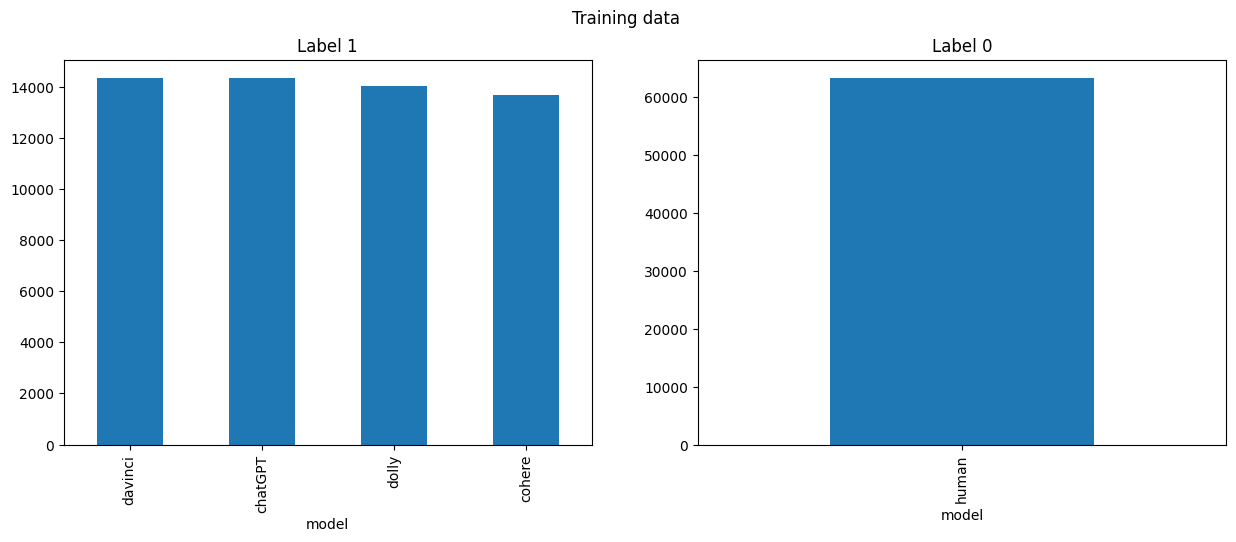

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Training data')
train_df[train_df['label'] == 1]['model'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
train_df[train_df['label'] == 0]['model'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

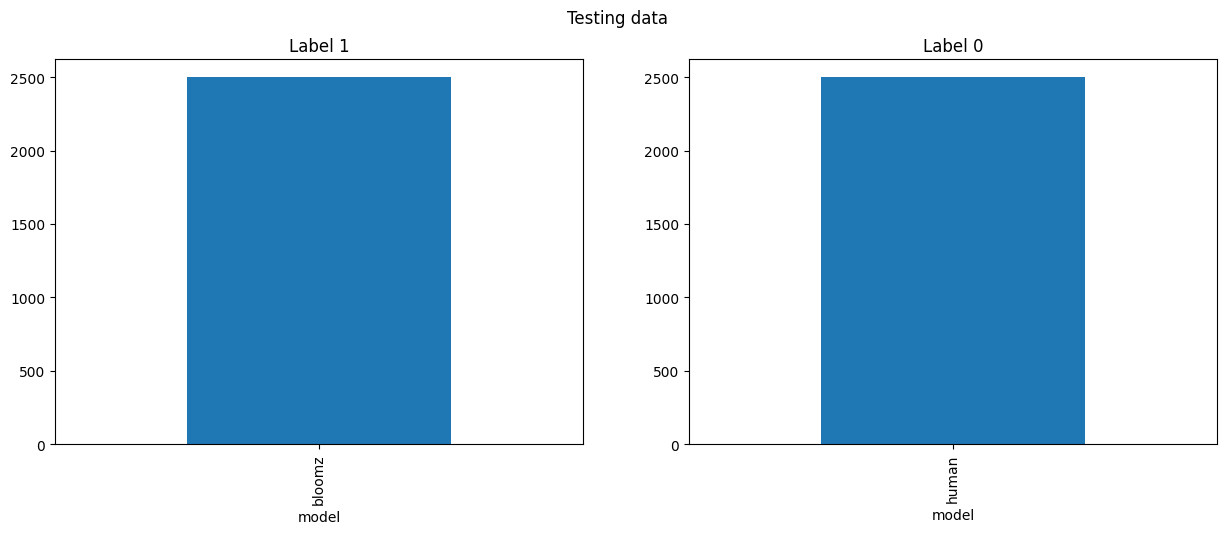

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Testing data')
test_df[test_df['label'] == 1]['model'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
test_df[test_df['label'] == 0]['model'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

The test data contains text generated from a different LLM, bloomz, not present in the models that generated texts for the training data

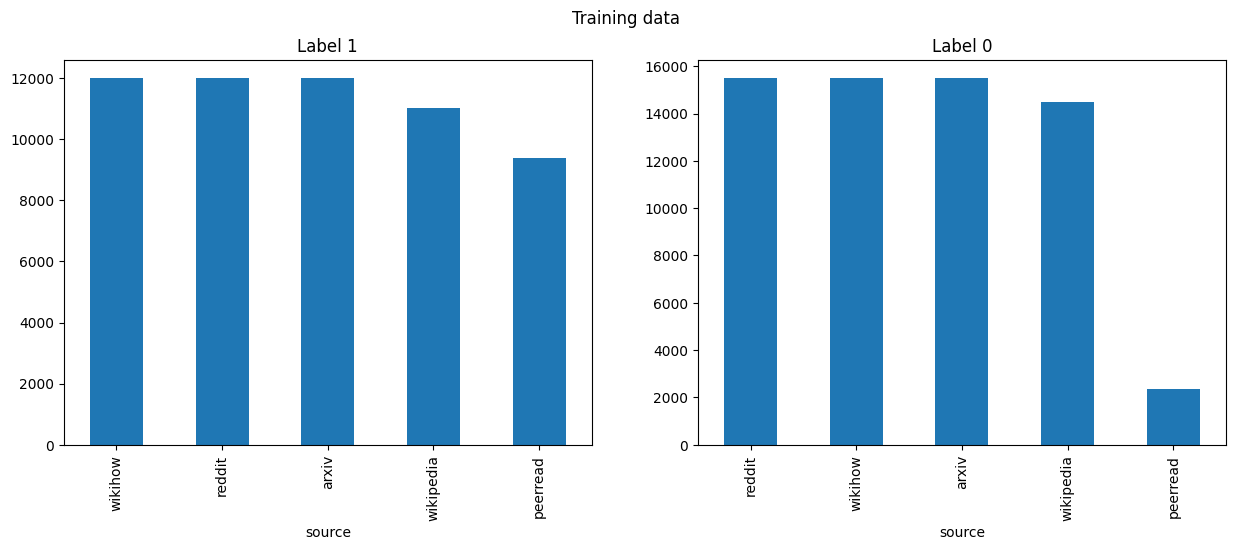

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Training data')
train_df[train_df['label'] == 1]['source'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
train_df[train_df['label'] == 0]['source'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

In [85]:
# TODO: what to do with the fact that we have much less peerread in the human written data??? Let's see how the model performs on pearread data 
# (it should be better in validation bcs unbalanced towards a class, but worse in test bcs balanced, see below)

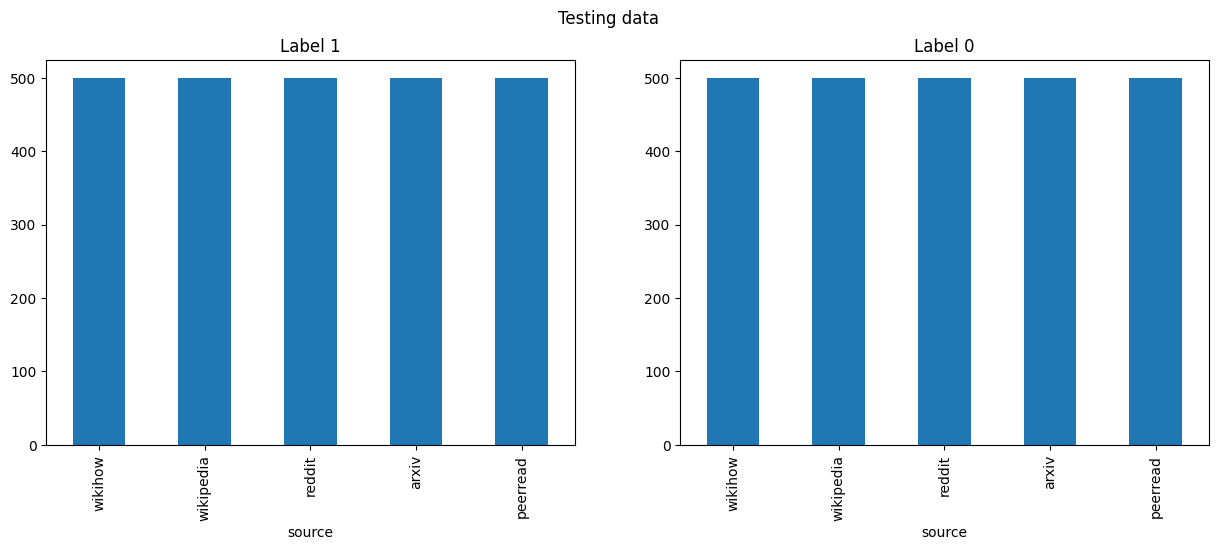

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Testing data')
test_df[test_df['label'] == 1]['source'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
test_df[test_df['label'] == 0]['source'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

The data is pretty balanced with respect to the fields "model" and "source".

We ignore these two in the following steps (as model would be only useful for a harder multiclass classification, source could be optionally passed to the model [TODO: try] to give more context) but keep them in the data to look for insights in the error analysis phase.

In [87]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))

In [88]:
train_df.head()

,text,label,model,source,word_count
id,,,,,
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,407
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,681
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,913
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,808
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,569


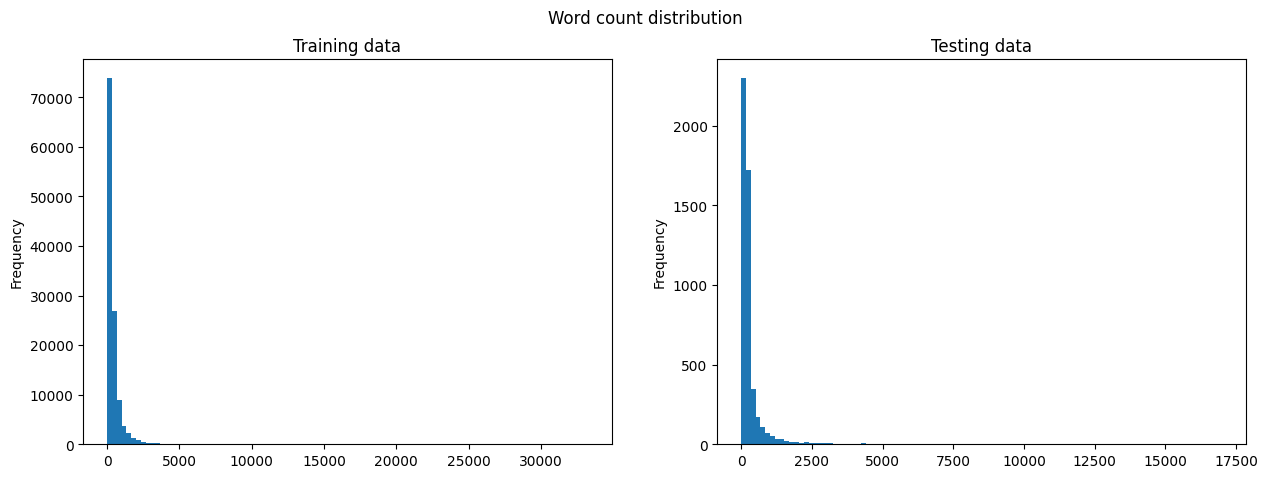

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Word count distribution')
train_df['word_count'].plot(kind='hist', bins=100, ax=axes[0], title='Training data');
test_df['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Testing data');

Plot considering 99.69% of the training data and 99.78% of the test data


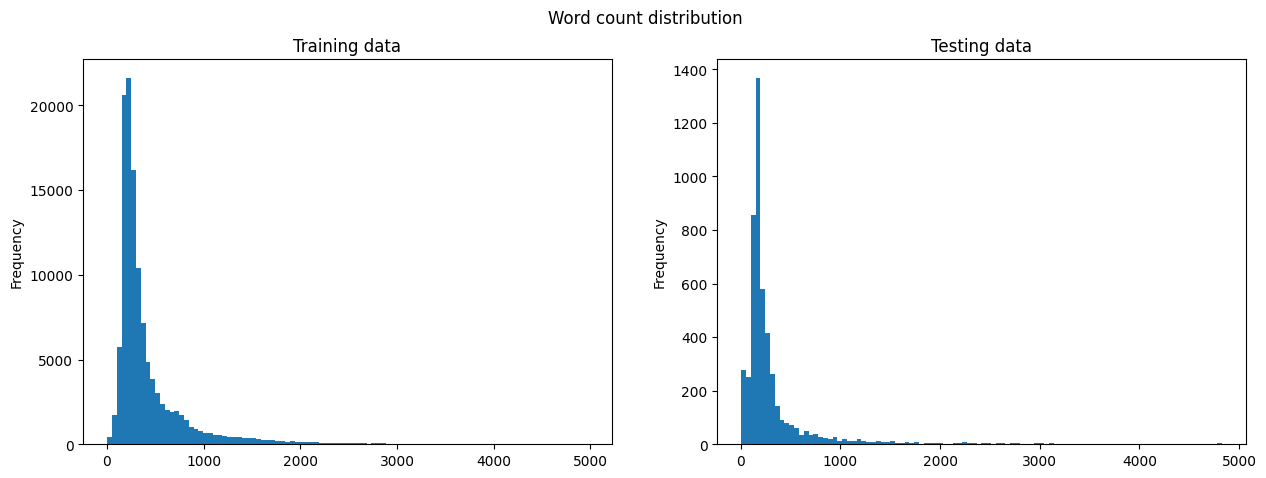

In [90]:
# Let's consider for a moment only the data below a certain threshold length (5000) for a more informative plot
print(f"Plot considering {len(train_df[train_df['word_count'] < 5000]) / len(train_df) * 100 :.2f}% of the training data and {len(test_df[test_df['word_count'] < 5000]) / len(test_df) * 100 :.2f}% of the test data")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Word count distribution')
train_df[train_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[0], title='Training data');
test_df[test_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Testing data');

In [97]:
print("Word count statistics for training set:")
print(train_df['word_count'].describe())

print("\n")
print("Word count statistics for test set:")
print(test_df['word_count'].describe())

Word count statistics for training set:
count    119757.000000
mean        460.905408
std         656.853708
min           2.000000
25%         204.000000
50%         279.000000
75%         462.000000
max       33223.000000
Name: word_count, dtype: float64


Word count statistics for test set:
count     5000.000000
mean       340.253000
std        609.282464
min          6.000000
25%        146.000000
50%        184.000000
75%        296.000000
max      16991.000000
Name: word_count, dtype: float64


Training and testing data are similar, or at least compatible, in terms of word counts of the texts, with test data having an clear decrease in word count

In [98]:
train_df.drop(columns='word_count', inplace=True)
test_df.drop(columns='word_count', inplace=True)

In [99]:
# TODO: more analysis of the different vocabularies of the different models and sources? of the vocabularies in general?

## Data preparation

In the lack of a complete train/val/test split, we considered the dataset provided as "development" (dev), i.e. validation set, as the test set and split the "train" dataset file using an **90/10 train/val split**.

We did so while maintaining class proportions invariate.

In [100]:
# N.B. don't re-execute this cell, otherwise the split will change

positive_df = train_df[train_df['label'] == 1]
negative_df = train_df[train_df['label'] == 0]

test_split = 0.1
positive_train_df, positive_val_df = train_test_split(positive_df, test_size=test_split, random_state=42)
negative_train_df, negative_val_df = train_test_split(negative_df, test_size=test_split, random_state=42)

train_df = pd.concat([positive_train_df, negative_train_df])
val_df = pd.concat([positive_val_df, negative_val_df])

# Shuffle the data
train_df = train_df.sample(frac=1)
val_df = val_df.sample(frac=1)

In [101]:
train_df.head()

,text,label,model,source
id,,,,
44473,\n\nThis paper examines the use of metonymy re...,1,davinci,peerread
97233,Since Game of Thrones is on a paid network wit...,0,human,reddit
78765,The York and Lancaster Regiment was a line inf...,0,human,wikipedia
50267,This paper addresses the problem of automatica...,1,dolly,peerread
51212,Decide if the New York State Museum is the bes...,1,dolly,wikihow


In [102]:
def print_stats(df, name):
    print(f"Stats for {name} data:")
    print(f"Number of texts: {len(df)}")
    print(f"Percentage of texts labeled as 1s (machine generated): {len(df[df['label'] == 1])/len(df)*100:.2f}% \n")

In [103]:
print_stats(train_df, "training")
print_stats(val_df, "validation")
print_stats(test_df, "test")

Stats for training data:
Number of texts: 107780
Percentage of texts labeled as 1s (machine generated): 47.10% 

Stats for validation data:
Number of texts: 11977
Percentage of texts labeled as 1s (machine generated): 47.10% 

Stats for test data:
Number of texts: 5000
Percentage of texts labeled as 1s (machine generated): 50.00% 



In [ ]:
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## Metrics

## Models

### Baseline

## Training

## Evaluation

## Error analysis